In [1]:
import os
import pandas as pd

path_2017 = '../../dataset/CICMalAnal2017/dynamic-dataset/logs'
path_2020 = '../../dataset/MalDroid-2020/dynamic-dataset/logs'

df_2017 = pd.read_csv(f'{path_2017}/logsCorrespondance.csv', delimiter=';')
df_2020 = pd.read_csv(f'{path_2020}/logsCorrespondance.csv', delimiter=';')

In [2]:
df_2017.head()

,UPI,monkeyInputSize,eventsActuallySent,timedOut,monkeySeed,outFilesName,Unnamed: 6
0,0034344c31f7b8812bc980d67ebd8dfec951d98d5786eb...,3,3,0,1.701793e+12,3-0034344c31f7b8812bc980d67ebd8dfec951d98d5786...,NaN
1,00997d815e09bcd9d594fae158f79a9d20722c5086bae7...,3,3,0,1.701789e+12,3-00997d815e09bcd9d594fae158f79a9d20722c5086ba...,NaN
2,00be2e75ca91895675879a869c24547f3f71edc7bdd6cb...,3,3,0,1.701884e+12,3-00be2e75ca91895675879a869c24547f3f71edc7bdd6...,NaN
3,00ecded5abccc7cc50a9d191ed901d321512de7257f765...,3,3,0,1.701832e+12,3-00ecded5abccc7cc50a9d191ed901d321512de7257f7...,NaN
4,0112ae505f5be62fa8f07ba6a2bfb0a47df65df5cbdf54...,3,3,0,1.701780e+12,3-0112ae505f5be62fa8f07ba6a2bfb0a47df65df5cbdf...,NaN


In [3]:
import plugin

strace_parser = plugin.strace.StraceParser()
monk_parser = plugin.monk.MonkParser()

In [4]:
def add_prefix(d, prefix):
    return {prefix + str(key): val for key, val in d.items()}

def extract_features(df_, monk_):
    calls = add_prefix(df_['sys_call'].value_counts().to_dict(), 'call_count_')
    ok_result = add_prefix(df_['sys_call_result_ok'].value_counts().to_dict(), 'ok_result_')
    address_result = add_prefix(df_['sys_call_return_address'].value_counts().to_dict(), 'address_result_')
    interpreted_result = add_prefix(df_['sys_call_result_interpreted'].value_counts().to_dict(), 'interpreted_')
    argument_data = add_prefix(df_['sys_call_arguments_count'].describe().to_dict(), 'arguments_')
    del argument_data['arguments_count']
    argument_path = add_prefix(df_['sys_call_arguments_contains_path'].value_counts().to_dict(), 'arguments_path_')
    monk_data = add_prefix(monk_, 'monk_data_')
    
    final = dict()
    final.update(calls)
    final.update(ok_result)
    final.update(address_result)
    final.update(interpreted_result)
    final.update(argument_data)
    final.update(argument_path)
    final.update(monk_data)
    return final

In [5]:
def fill_na_avg(df_, columns_):
    for column in columns_:
        for col in df_.columns:
            if col.startswith(column):
                df_[col].fillna((df_[col].mean()), inplace=True)
    return df_


def fill_na_zero(df_, columns_):
    for column in columns_:
        for col in df_.columns:
            if col.startswith(column):
                df_[col].fillna(0, inplace=True)
    return df_


In [6]:
fill_avg = ['arguments_']
fill_zero = ['call_count_', 'ok_result_', 'address_result_', 'interpreted_', 'arguments_path_']

dataset_dynamic = []

for i, row in df_2017.iterrows():
    fname = row['outFilesName']
    bin_hash = row['UPI']
    path = os.path.join(path_2017, fname)
    
    strace_path = path + '.trace'
    monk_path = path + '.monkdata'
    if not os.path.exists(strace_path) or not os.path.exists(monk_path):
        print(f'[ERROR] Could not analyze {strace_path}')
        continue
    df = strace_parser.parse_trace(file=strace_path)
    monk = monk_parser.parse_monk_data(file=monk_path)
    try:
        data = extract_features(df_=df, monk_=monk)
        data['sha256'] = bin_hash
        dataset_dynamic.append(data)
    except:
        pass

for i, row in df_2017.iterrows():
    fname = row['outFilesName']
    bin_hash = row['UPI']
    path = os.path.join(path_2020, fname)
    strace_path = path + '.trace'
    monk_path = path + '.monkdata'
    if not os.path.exists(strace_path) or not os.path.exists(monk_path):
        print(f'[ERROR] Could not analyze {strace_path}')
        continue
    df = strace_parser.parse_trace(file=strace_path)
    monk = monk_parser.parse_monk_data(file=monk_path)
    try:
        data = extract_features(df_=df, monk_=monk)
        data['sha256'] = bin_hash
        dataset_dynamic.append(data)
    except:
        pass


[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-0034344c31f7b8812bc980d67ebd8dfec951d98d5786eb201f3ccfeca427cc54.monkdata
[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-00997d815e09bcd9d594fae158f79a9d20722c5086bae7e20d9292e8e1c49a10.monkdata
[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-00be2e75ca91895675879a869c24547f3f71edc7bdd6cb873a7c8d421a9778a0.monkdata
[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-00ecded5abccc7cc50a9d191ed901d321512de7257f765a248e9b23cc2fb8f5d.monkdata
[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-0112ae505f5be62fa8f07ba6a2bfb0a47df65df5cbdf5428871c1766c235f44c.monkdata
[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-01197158a830b73b55e28918f2db8b50b78d9564325535560932d189cf2169c7.monkdata
[monk-parser] Evaluating: ../../dataset/CICMalAnal2017/dynamic-dataset/logs/3-017c70f47d

In [7]:
df = pd.DataFrame(dataset_dynamic)
df = fill_na_avg(df, fill_avg)
df = fill_na_zero(df, fill_zero)
df

,call_count_newfstatat,call_count_mmap,call_count_openat,call_count_prctl,call_count_mprotect,call_count_futex,call_count_write,call_count_pread64,call_count_getuid,call_count_writev,...,arguments_path_True,monk_data_elapsed,monk_data_mobile,monk_data_wifi,monk_data_not_connected,monk_data_error,sha256,call_count_faccessat,call_count_exit,call_count_membarrier
0,85.0,83,69.0,65,60.0,48.0,47.0,44.0,41.0,32.0,...,195.0,35,0,0,35,False,0034344c31f7b8812bc980d67ebd8dfec951d98d5786eb...,0.0,0.0,0.0
1,101.0,87,77.0,59,60.0,42.0,50.0,52.0,39.0,32.0,...,223.0,24,0,0,24,False,00997d815e09bcd9d594fae158f79a9d20722c5086bae7...,1.0,0.0,0.0
2,90.0,82,76.0,60,56.0,48.0,52.0,50.0,36.0,32.0,...,210.0,45,0,0,45,False,00be2e75ca91895675879a869c24547f3f71edc7bdd6cb...,0.0,0.0,0.0
3,90.0,91,77.0,58,58.0,39.0,50.0,51.0,40.0,33.0,...,211.0,862,0,0,862,False,00ecded5abccc7cc50a9d191ed901d321512de7257f765...,0.0,1.0,0.0
4,94.0,76,77.0,51,52.0,40.0,54.0,52.0,42.0,35.0,...,218.0,15,0,0,15,False,0112ae505f5be62fa8f07ba6a2bfb0a47df65df5cbdf54...,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,91.0,90,78.0,60,63.0,49.0,51.0,52.0,41.0,31.0,...,218.0,15,0,0,15,False,ff36a847d606fb9d4868ef1c2356e8581e81f22f850872...,0.0,0.0,1.0
1353,92.0,94,82.0,66,69.0,44.0,54.0,52.0,42.0,33.0,...,222.0,42,0,0,42,False,ff591954001cd2feda22390074cf565c20f16014ea3809...,0.0,0.0,2.0
1354,94.0,89,73.0,45,53.0,35.0,42.0,51.0,33.0,26.0,...,211.0,18,0,0,18,False,ffa7a5b40861d88abe9bdb54ddf039ec92c4e561d32d1b...,0.0,0.0,0.0
1355,90.0,92,76.0,63,61.0,52.0,52.0,52.0,41.0,33.0,...,207.0,25,0,0,25,False,ffd18e98d44eae611d5655159e577859cd8eecf0d04925...,0.0,0.0,0.0


In [8]:
summary = pd.read_csv('../../dataset/dataset-joined.csv')
df = df.join(summary.set_index('sha256'), on='sha256', rsuffix='_summary')

In [40]:
import matplotlib.pyplot as plt

def plot_pie(df_, column_):
    data = df_[column_].value_counts()
    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Dataset Distribution Across Sample Type')
    plt.show()

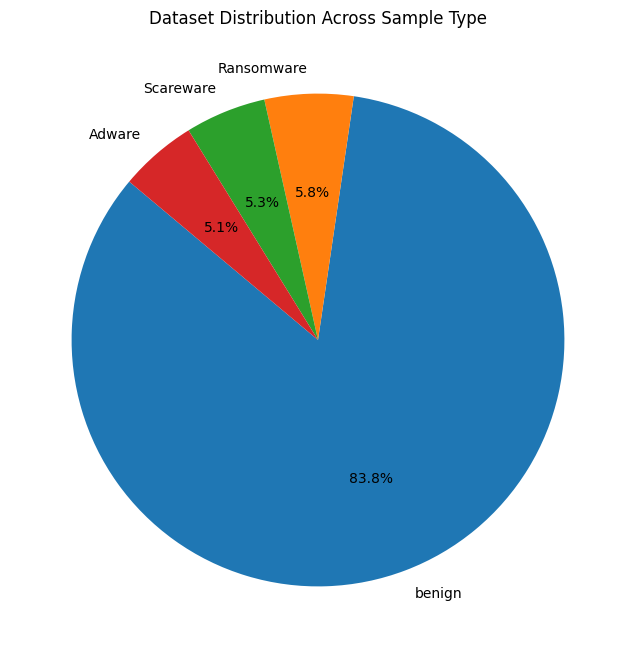

In [41]:
plot_pie(df_=df, column_='type')

In [11]:
df.to_csv('../../dataset/dataset-dynamic-joined.csv', index=False)

In [12]:
import pandas as pd
import plugin

In [13]:
df = pd.read_csv('../../dataset/dataset-dynamic-joined.csv')

In [14]:
def generate_class_features(df_):
    access_flags = df_['access_flags'].describe().to_dict()
    num_methods = df_['num_methods'].describe().to_dict()
    num_fields = df_['num_fields'].describe().to_dict()
    num_direct_methods = df_['num_direct_methods'].describe().to_dict()
    num_static_fields = df_['num_static_fields'].describe().to_dict()
    num_virtual_methods = df_['num_virtual_methods'].describe().to_dict()

    # Join these dicts into one with a pre-fix for each
    # Add prefix to each dict
    access_flags = add_prefix(access_flags, 'access_flags_')
    num_methods = add_prefix(num_methods, 'num_methods_')
    num_fields = add_prefix(num_fields, 'num_fields_')
    num_direct_methods = add_prefix(num_direct_methods, 'num_direct_methods_')
    num_static_fields = add_prefix(num_static_fields, 'num_static_fields_')
    num_virtual_methods = add_prefix(num_virtual_methods, 'num_virtual_methods_')

    # Combine all dicts into one
    final_dict = dict()
    final_dict.update(access_flags)
    final_dict.update(num_methods)
    final_dict.update(num_fields)
    final_dict.update(num_direct_methods)
    final_dict.update(num_static_fields)
    final_dict.update(num_virtual_methods)
    final_dict = add_prefix(final_dict, 'class_')
    return final_dict


def generate_method_features(df_):
    access_flags = df_['access_flags'].describe().to_dict()
    size = df_['size'].describe().to_dict()
    registers_size = df_['registers_size'].describe().to_dict()
    ins_size = df_['ins_size'].describe().to_dict()
    outs_size = df_['outs_size'].describe().to_dict()
    tries_size = df_['tries_size'].describe().to_dict()
    
    # Join these dicts into one with a pre-fix for each
    # Add prefix to each dict
    access_flags = add_prefix(access_flags, 'access_flags_')
    size = add_prefix(size, 'size_')
    registers_size = add_prefix(registers_size, 'registers_size_')
    ins_size = add_prefix(ins_size, 'ins_size_')
    outs_size = add_prefix(outs_size, 'outs_size_')
    tries_size = add_prefix(tries_size, 'tries_size_')
    
    # Combine all dicts into one
    final_dict = dict()
    final_dict.update(access_flags)
    final_dict.update(size)
    final_dict.update(registers_size)
    final_dict.update(ins_size)
    final_dict.update(outs_size)
    final_dict.update(tries_size)
    final_dict = add_prefix(final_dict, 'method_')
    return final_dict

def generate_features(classes_, methods_, summary_):
    df_classes = pd.DataFrame(classes_)
    df_methods = pd.DataFrame(methods_)
    
    df_classes = df_classes.fillna(0)
    df_methods = df_methods.fillna(0)
    
    class_feats_ = generate_class_features(df_=df_classes)
    method_feats_ = generate_method_features(df_=df_methods)
    
    final_dict = dict()
    final_dict.update(method_feats_)
    final_dict.update(class_feats_)
    final_dict.update(summary_)
    
    return final_dict


In [15]:
from tqdm import tqdm 

static_results = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    try:
        apk = str(row['file_path'])
        apk = apk.replace('./dataset', '../../dataset')
        static_analyzer = plugin.static.StaticAnalysis()
        summary, classes, methods = static_analyzer.analyze(apk)
        features = generate_features(classes_=classes, methods_=methods, summary_=summary)
        features['sha256'] = row['sha256']
        static_results.append(features)
    except:
        pass

100%|██████████| 1357/1357 [1:00:15<00:00,  2.66s/it]


In [36]:
fill_avg = ['size_', 'registers_size_', 'ins_size_', 'outs_size_', 'tries_size_', 'num_activities', 'total_classes', 'method_', 'class_']
fill_zero = ['access_flags_', 'permission_']
metadata_columns = ['monk_data_error', 'md5', 'file_path', 'sha256']

df_static = pd.DataFrame(static_results)

df_final = df.join(df_static.set_index('sha256'), on='sha256', rsuffix='_static')
df_final = fill_na_avg(df_final, fill_avg)
df_final = fill_na_zero(df_final, fill_zero)
df_final

,call_count_newfstatat,call_count_mmap,call_count_openat,call_count_prctl,call_count_mprotect,call_count_futex,call_count_write,call_count_pread64,call_count_getuid,call_count_writev,...,permission_com.accessbank.accessbankapp.permission.C2D_MESSAGE,permission_com.keyideas.indianrailways.permission.C2D_MESSAGE,permission_com.unearby.sayhi.permission.C2D_MESSAGE,permission_com.unearby.sayhi.permission.MAPS_RECEIVE,permission_basic.guru.gforms.permission.C2D_MESSAGE,permission_com.minus.android.permission.C2D_MESSAGE,permission_uk.co.avoir.accord.permission.C2D_MESSAGE,permission_com.blackboard.mosaic.lousdk12caus.permission.C2D_MESSAGE,permission_com.im.urbancyclist.permission.C2D_MESSAGE,permission_com.im.urbancyclist.permission.UA_DATA
0,85.0,83,69.0,65,60.0,48.0,47.0,44.0,41.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101.0,87,77.0,59,60.0,42.0,50.0,52.0,39.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90.0,82,76.0,60,56.0,48.0,52.0,50.0,36.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90.0,91,77.0,58,58.0,39.0,50.0,51.0,40.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,94.0,76,77.0,51,52.0,40.0,54.0,52.0,42.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,91.0,90,78.0,60,63.0,49.0,51.0,52.0,41.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1353,92.0,94,82.0,66,69.0,44.0,54.0,52.0,42.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1354,94.0,89,73.0,45,53.0,35.0,42.0,51.0,33.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1355,90.0,92,76.0,63,61.0,52.0,52.0,52.0,41.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
df_final.isna().any()

call_count_newfstatat                                                   False
call_count_mmap                                                         False
call_count_openat                                                       False
call_count_prctl                                                        False
call_count_mprotect                                                     False
                                                                        ...  
permission_com.minus.android.permission.C2D_MESSAGE                     False
permission_uk.co.avoir.accord.permission.C2D_MESSAGE                    False
permission_com.blackboard.mosaic.lousdk12caus.permission.C2D_MESSAGE    False
permission_com.im.urbancyclist.permission.C2D_MESSAGE                   False
permission_com.im.urbancyclist.permission.UA_DATA                       False
Length: 1282, dtype: bool

In [39]:
df_final.to_csv('../../dataset/dataset-dynamic-static-joined.csv', index=False)